In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [2]:
import os 
if not os.path.isdir("Plate-Detection"):
  os.makedirs("Plate-Detection")
%cd /content/drive/MyDrive/Plate-Detection

/content/drive/MyDrive/Plate-Detection


In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
if not os.path.isdir("car-plate-detection"):
  od.download("https://www.kaggle.com/datasets/andrewmvd/car-plate-detection")

In [ ]:
dataset = {
            "file":[],
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],
            "xmax":[],
            "ymax":[],
           "classes":[]
           
           }

In [ ]:
from glob import glob as gb
import xml.etree.ElementTree as ET

for item in gb("car-plate-detection/annotations/*.xml"):
    tree = ET.parse(item)
    
    for elem in tree.iter():
        if 'filename' in elem.tag:
            filename=elem.text
        elif 'width' in elem.tag:
            width=int(elem.text)
        elif 'height' in elem.tag:
            height=int(elem.text)
        elif 'xmin' in elem.tag:
            xmin=int(elem.text)
        elif 'ymin' in elem.tag:
            ymin=int(elem.text)
        elif 'xmax' in elem.tag:
            xmax=int(elem.text)
        elif 'ymax' in elem.tag:
            ymax=int(elem.text)
            
            dataset['file'].append(filename)
            dataset['width'].append(width)
            dataset['height'].append(height)
            dataset['xmin'].append(xmin)
            dataset['ymin'].append(ymin)
            dataset['xmax'].append(xmax)
            dataset['ymax'].append(ymax)
            dataset['classes'].append(0)

In [ ]:
import pandas as pd
df=pd.DataFrame(dataset)
df

,file,width,height,xmin,ymin,xmax,ymax,classes
0,Cars0.png,500,268,226,125,419,173,0
1,Cars1.png,400,248,134,128,262,160,0
2,Cars10.png,400,225,140,5,303,148,0
3,Cars100.png,400,267,175,114,214,131,0
4,Cars101.png,400,300,167,202,240,220,0
...,...,...,...,...,...,...,...,...
466,Cars95.png,600,400,278,182,407,263,0
467,Cars96.png,400,248,133,126,261,160,0
468,Cars97.png,400,300,98,102,297,191,0
469,Cars98.png,370,400,85,196,247,259,0


In [ ]:
df['w']=(df["xmax"]-df["xmin"])/df['width']
df['h']=(df["ymax"]-df["ymin"])/df['height']

df["xcenter"]=((df["xmax"]+df["xmin"])/2)/df['width']
df["ycenter"]=((df["ymax"]+df["ymin"])/2)/df['height']

name=df["file"].apply(lambda x: x.split("."))
z=[]
for i in name:
     z.append(i[0])
df['file']=z



df=df[["file","w","h","xcenter","ycenter","classes"]]
df.head(10)

,file,w,h,xcenter,ycenter,classes
0,Cars0,0.386000,0.179104,0.645000,0.555970,0
1,Cars1,0.320000,0.129032,0.495000,0.580645,0
2,Cars10,0.407500,0.635556,0.553750,0.340000,0
3,Cars100,0.097500,0.063670,0.486250,0.458801,0
4,Cars101,0.182500,0.060000,0.508750,0.703333,0
5,Cars102,0.731429,0.197719,0.554286,0.657795,0
6,Cars103,0.045000,0.025510,0.597500,0.670918,0
7,Cars103,0.032500,0.025510,0.488750,0.604592,0
8,Cars104,0.098000,0.042781,0.439000,0.732620,0
9,Cars105,0.135000,0.050000,0.447500,0.637500,0


In [ ]:
from tqdm import tqdm
for name,mini in tqdm(df.groupby('file')):
  if not os.path.exists('/content/drive/MyDrive/Plate-Detection/car-plate-detection/txt-labels'):
                os.makedirs('/content/drive/MyDrive/Plate-Detection/car-plate-detection/txt-labels')
  with open('/content/drive/MyDrive/Plate-Detection/car-plate-detection/txt-labels/'+name+".txt", 'w+') as f:
                row = mini[['classes','xcenter','ycenter','w','h']].astype(float).values
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write(" \n ")

100%|██████████| 433/433 [00:02<00:00, 166.96it/s]


In [ ]:
print("number of images :" + str(len(os.listdir("car-plate-detection/images"))))
print("number of annotations .XML : "+ str(len(os.listdir("car-plate-detection/annotations"))))
print("number of annotations .txt : "+str(len(os.listdir("car-plate-detection/txt-labels"))))

number of images :433
number of annotations .XML : 433
number of annotations .txt : 433


In [ ]:
#splitting the data:
from sklearn.model_selection import train_test_split 
X= os.listdir("car-plate-detection/images")
y=os.listdir("car-plate-detection/txt-labels")

Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=.1,shuffle=True)
Xtrain,Xval,ytrain,yval=train_test_split(Xtrain,ytrain,test_size=.1,shuffle=True)


In [ ]:
print("number of train images :" ,len(Xtrain))
print("number of test images :" ,len(Xtest))
print("number of val images :" ,len(Xval))

print("number of train annotations: ",len(ytrain))
print("number of test annotations: ",len(ytest))
print("number of val annotations: ",len(yval))

number of train images : 350
number of test images : 44
number of val images : 39
number of train annotations:  350
number of test annotations:  44
number of val annotations:  39


In [ ]:
import shutil as sh 
images=os.listdir("car-plate-detection/images")
 
#images:
for i in images:
  if i in Xtrain:
    path2save="Train"
  elif i in Xval:
    path2save="Val"
  elif i in Xtest :
     path2save="Test"
  
  if not os.path.exists("/content/drive/MyDrive/Plate-Detection/car-plate-detection/{}/images".format(path2save)):
         os.makedirs("/content/drive/MyDrive/Plate-Detection/car-plate-detection/{}/images".format(path2save))
  sh.move("/content/drive/MyDrive/Plate-Detection/car-plate-detection/images/{}".format(i), "/content/drive/MyDrive/Plate-Detection/car-plate-detection/{}/images/{}".format(path2save,i))

In [ ]:
annotations =os.listdir("car-plate-detection/txt-labels")
#for annotations:
for i in annotations:
  if i in ytrain:
    path2save="Train"
  elif i in yval:
    path2save="Val"
  elif i in ytest :
     path2save="Test"
  
  if not os.path.exists("/content/drive/MyDrive/Plate-Detection/car-plate-detection/{}/labels".format(path2save)):
         os.makedirs("/content/drive/MyDrive/Plate-Detection/car-plate-detection/{}/labels".format(path2save))
  sh.move("/content/drive/MyDrive/Plate-Detection/car-plate-detection/txt-labels/{}".format(i), "/content/drive/MyDrive/Plate-Detection/car-plate-detection/{}/labels/{}".format(path2save,i))

# downloading YOlO:

In [ ]:
import os 
if not os.path.isdir("Yolo"):
  os.makedirs("Yolo")
%cd /content/drive/MyDrive/Plate-Detection/Yolo

/content/drive/MyDrive/Plate-Detection/Yolo


In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15114, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 15114 (delta 10), reused 5 (delta 1), pack-reused 15088
Receiving objects: 100% (15114/15114), 13.74 MiB | 7.62 MiB/s, done.
Resolving deltas: 100% (10443/10443), done.


In [ ]:
%cd yolov5 
!pip install -r requirements.txt

/content/drive/MyDrive/Plate-Detection/Yolo/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.2 MB/s eta 0:00:00


In [3]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
model

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-19 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)



requirements: /usr/local/lib/python3.10/dist-packages/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

(-0.5, 999.5, 562.5, -0.5)

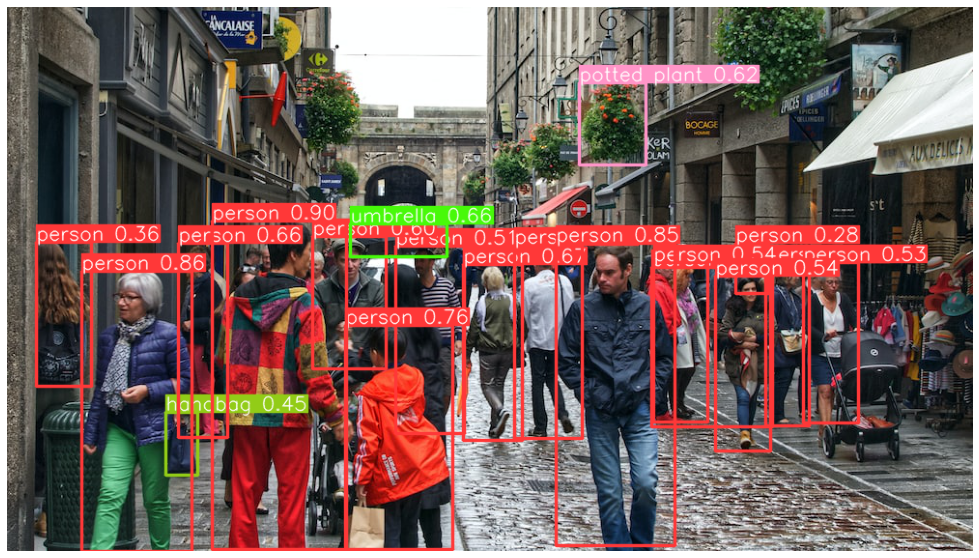

In [ ]:
img = r"https://images.unsplash.com/photo-1616753677823-bc8270e35ec1?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1000&q=80"
results = model(img)
%matplotlib inline
plt.figure(figsize=(20,10))
plt.imshow(np.squeeze(results.render()))
plt.axis("off")

In [ ]:
Data_Path = "/content/drive/MyDrive/Plate-Detection/car-plate-detection"
with open(f"/content/drive/MyDrive/Plate-Detection/car-plate-detection/plate.yaml", "w+") as file_:
        file_.write(
           f"""
           train: /{Data_Path}/Train/images  
           val: /{Data_Path}/Val/images  
           test:  # test images (optional)
           nc: 1
           names: ["licence"]
            
            """
)

In [ ]:
pwd

'/content/drive/MyDrive/Plate-Detection/Yolo/yolov5'

In [ ]:
!python train.py --batch 32 --epochs 50 --data  /content/drive/MyDrive/Plate-Detection/car-plate-detection/plate.yaml --cfg /content/drive/MyDrive/Plate-Detection/Yolo/yolov5/models/yolov5s.yaml --name plate-detection

train: weights=yolov5s.pt, cfg=/content/drive/MyDrive/Plate-Detection/Yolo/yolov5/models/yolov5s.yaml, data=/content/drive/MyDrive/Plate-Detection/car-plate-detection/plate.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=plate-detection, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-252-g946765b Python-3.7.15 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup

In [4]:
!pip install ultralytics


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.5/586.5 kB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 24.4 MB/s eta 0:00:00


In [5]:
plate = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/Plate-Detection/Yolo/yolov5/runs/train/plate-detection/weights/best.pt', force_reload=True)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-5-19 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)



requirements: /usr/local/lib/python3.10/dist-packages/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


In [6]:
!pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.9/813.9 kB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.7.0.72
    Uninstalling opencv-python-headless-4.7.0.72:
      Successfully uninstalled opencv-python-headless-4.7.0.72


In [38]:
def draw_bounding_box(image, x1, y1, x2, y2, label):

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    label_size, _ = cv2.getTextSize(label, font, font_scale, 2)
    label_x = x1 + 5
    label_y = y1 + label_size[1] - 5
    cv2.rectangle(image, (x1, y1-20), (x1 + label_size[0], y1 + label_size[1]-10), (0, 255, 0), -1)
    cv2.putText(image, label, (label_x-5, label_y-10), font, font_scale, (0, 0, 0), 1)



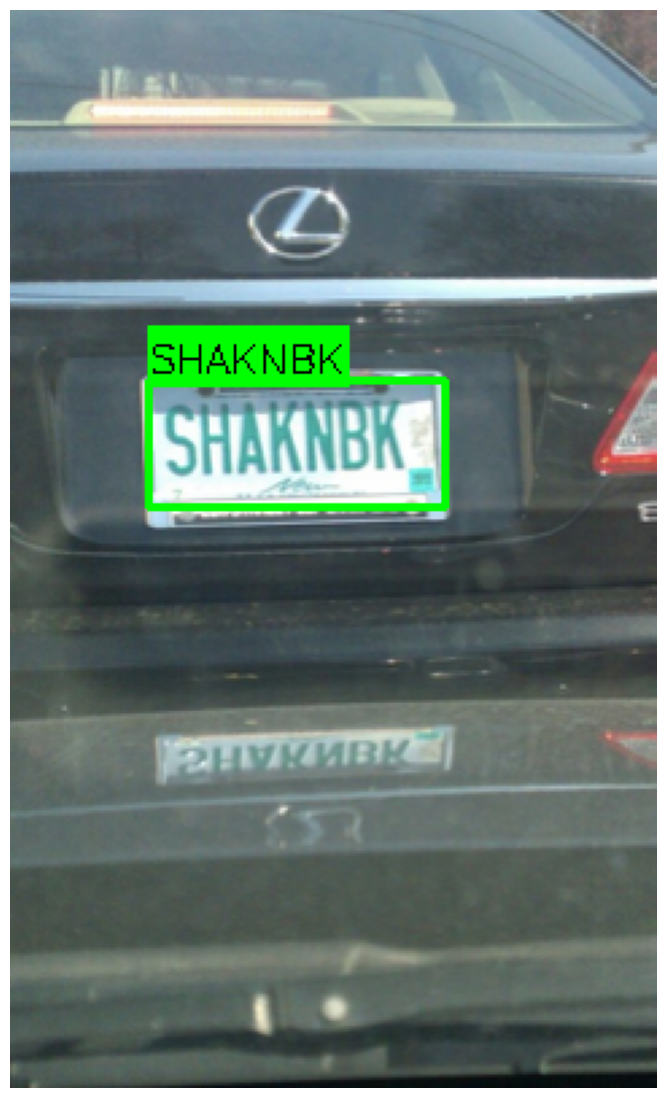

In [39]:
import easyocr
import matplotlib.pyplot as plt
%matplotlib inline


test=os.listdir("car-plate-detection/Test/images")
index=np.random.randint(len(test))

image=cv2.imread("car-plate-detection/Test/images/"+str(test[index]))
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

detected=plate(image)

f=detected.xyxy[0]
f=f.cpu().numpy()
for i in range(f.shape[0]):
  x=int(f[i][0])
  y=int(f[i][1])
  w=int(f[i][2])
  h=int(f[i][3])
cropped_image = image[y:y+h, x:x+w]
reader=easyocr.Reader(['en'])
plat_num=reader.readtext(cropped_image)
if not plat_num ==[]:
  draw_bounding_box(image,x,y,w,h,plat_num[0][1])

plt.figure(figsize=(20,14))
plt.imshow(image)
plt.axis('off')
plt.show()